# Setup

In [ ]:
%%capture

%load_ext autoreload
%autoreload 2

!pip install filterpy

In [ ]:

import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm
from filterpy.kalman import EnsembleKalmanFilter as EnKF
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import griddata
import jax


In [ ]:
if os.path.isdir('./ACM270_Model_Error/') == False:
    ! git clone https://github.com/sreemanti-dey/ACM270_Model_Error.git
sys.path.append('./ACM270_Model_Error/')

! cd ACM270_Model_Error

# True Trajectory and Noisy Observations with 2-Scale Lorenz96

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit,random

# parameters for two-scale L96
K = 36                      # number of large scale vars
J = 10                      # number of small scale vars per large var
h = 0.25                   # part of coupling
c = 10                     # part of coupling
b = 10                     # part of coupling
F = 10                     # forcing
dt = 0.05                  # time step
num_steps = 200
time_steps = num_steps

@jit
def L96_2(xy):
    x = xy[0:K]
    y = xy[K:].reshape(K, J)

    dx = jnp.zeros(K)
    dy = jnp.zeros((K, J))

    for k in range(K):
        dxdt = -1 * x[k - 1] * (x[k - 2] - x[(k + 1) % K]) - x[k] + F - (h * c / b) * jnp.sum(y[k])
        dx = dx.at[k].set(dxdt)

        for j in range(J):
            dydt = -1 * c * b * y[k, (j + 1) % J] * (y[k, (j + 2) % J] - y[k, j - 1]) - c * y[k, j] + (h * c / b) * x[k]
            dy = dy.at[k, j].set(dydt)

    return jnp.concatenate([dx, dy.flatten()])

@jit
def rk4_step_lorenz96_2(x):
    f = lambda y: L96_2(y)
    k1 = dt * f(x)
    k2 = dt * f(x + k1/2)
    k3 = dt * f(x + k2/2)
    k4 = dt * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

keys = iter(random.split(random.PRNGKey(0), 10))
key = random.PRNGKey(0)
# randomized starting point for large scale, 0 for small scale
x0 = np.linspace(0, 1, K)  # np.random.rand(K)
y0 = np.zeros((K, J))
xy0 = np.concatenate([x0, y0.flatten()])

rk4_step_lorenz96_2(xy0)


Array([0.43371984, 0.50528324, 0.54347545, 0.57038236, 0.5975787 ,
       0.62485427, 0.6521283 , 0.6794018 , 0.70667535, 0.73394895,
       0.76122254, 0.78849614, 0.8157696 , 0.8430432 , 0.8703168 ,
       0.89759034, 0.92486393, 0.95213753, 0.9794111 , 1.0066847 ,
       1.0339583 , 1.0612317 , 1.0885054 , 1.1157789 , 1.1430525 ,
       1.1703261 , 1.1975996 , 1.2248732 , 1.2521468 , 1.2794204 ,
       1.3066939 , 1.3339674 , 1.3612406 , 1.3884815 , 1.4140453 ,
       1.3828632 , 0.00234739, 0.00234739, 0.00234739, 0.00234739,
       0.00234739, 0.00234739, 0.00234739, 0.00234739, 0.00234739,
       0.00234739, 0.00286182, 0.00286182, 0.00286182, 0.00286182,
       0.00286182, 0.00286182, 0.00286182, 0.00286182, 0.00286182,
       0.00286182, 0.00317611, 0.00317611, 0.00317611, 0.00317611,
       0.00317611, 0.00317611, 0.00317611, 0.00317611, 0.00317611,
       0.00317611, 0.00344901, 0.00344901, 0.00344901, 0.00344901,
       0.00344901, 0.00344901, 0.00344901, 0.00344901, 0.00344

In [ ]:
trajectory = jnp.zeros((time_steps, len(xy0)))
noisy_obs = jnp.zeros((time_steps, len(xy0)))
noise_covar = jnp.eye(len(xy0)) * 0.1

xy = xy0
for i in tqdm(range(time_steps)):
    xy = rk4_step_lorenz96_2(xy)
    trajectory = trajectory.at[i].set(xy)
    # Add noise to the observations
    noise = random.multivariate_normal(key, jnp.zeros(len(xy0)), noise_covar)
    noisy_obs = noisy_obs.at[i].set(xy + noise)
    key, _ = random.split(key)  # Update key for the next iteration



100%|██████████| 200/200 [00:02<00:00, 83.99it/s] 


## True Trajectory

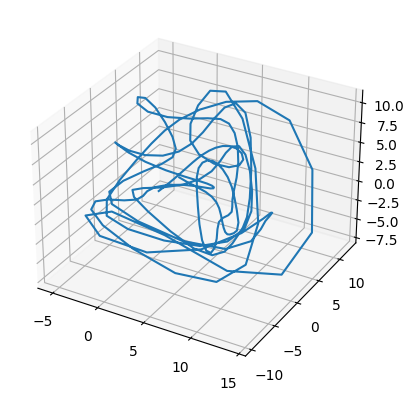

In [ ]:
ax = plt.axes(projection ='3d')
ax.plot3D(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])
# ax.set_title("First 3 Variables of True 2-Scale L96 Trajectory")
plt.savefig(f'proj_traj.png', bbox_inches="tight", dpi=500)
#plt.show()

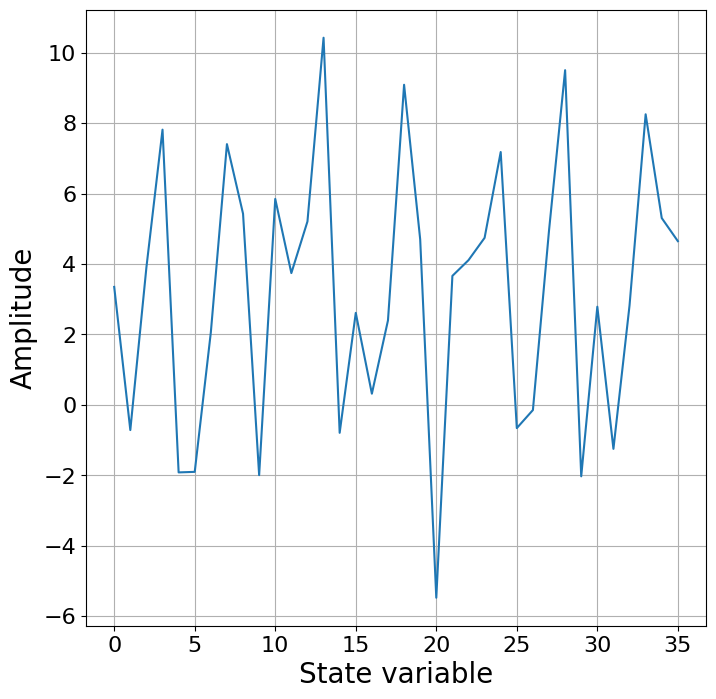

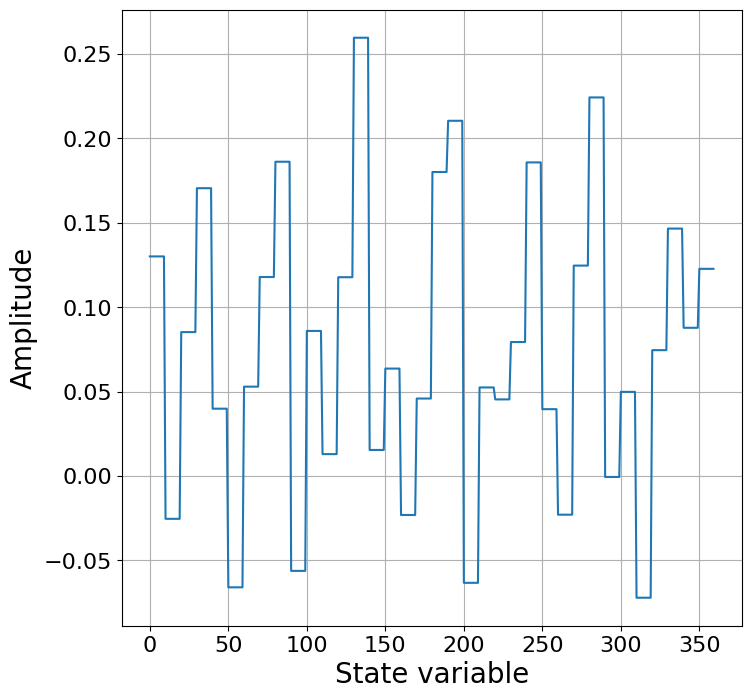

In [ ]:
# fig, axs = plt.subplots(2, figsize=(8, 7))

# fig.suptitle("Cross Section of 2-Scale L96 Trajectory")

# axs[0].plot(trajectory[400, :K])
# axs[0].set_ylabel("Amplitude")
# axs[0].set_title("Large Scale")

# axs[1].plot(trajectory[400, K:])
# axs[1].set_xlabel("t")
# axs[1].set_ylabel("Amplitude")
# axs[1].set_title("Small Scale")


plt.figure(figsize=(8, 8))

plt.plot(trajectory[400, :K])
plt.xlabel("State variable",fontsize=20)
plt.ylabel("Amplitude",fontsize=20)
plt.grid(True)
plt.xticks(fontsize=20 / 1.25)
plt.yticks(fontsize=20 / 1.25)
plt.savefig(f'large_scale.png', bbox_inches="tight", dpi=500)

plt.figure(figsize=(8, 8))

plt.plot(trajectory[400, K:])
plt.xlabel("State variable",fontsize=20)
plt.ylabel("Amplitude",fontsize=20)
plt.grid(True)
plt.xticks(fontsize=20 / 1.25)
plt.yticks(fontsize=20 / 1.25)
plt.savefig(f'small_scale.png', bbox_inches="tight", dpi=500)

## Noisy Observations

In [ ]:
true_states = trajectory

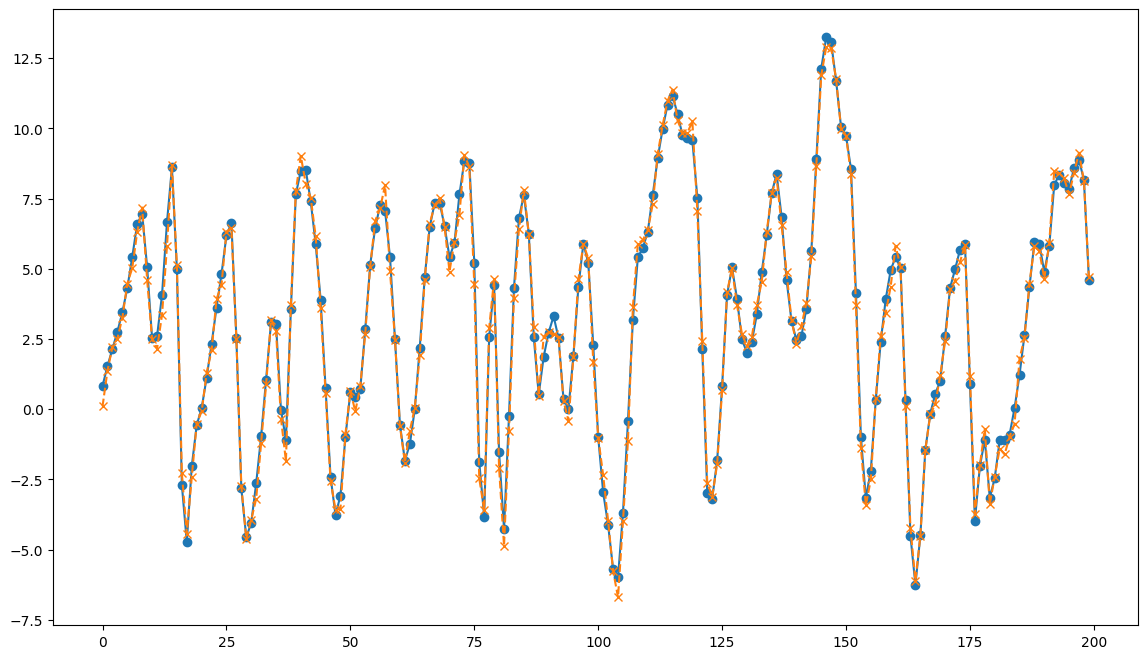

In [ ]:
plt.figure(figsize=(14, 8))
i = 0
time = jnp.arange(200)

plt.plot(time, true_states[:,0], label=f'True state {i+1}', linestyle='-', marker='o')
plt.plot(time, noisy_obs[:,0], label=f'Noisy Obs {i+1}', linestyle='--', marker='x')

In [ ]:
np.save("true_trajectory.npy", trajectory)
np.save("noisy_obs.npy", noisy_obs)

# EnKF for 1-Scale Assimilation

In [ ]:
@jit
def rk4_step_lorenz96_1(x):
    f = lambda y: (jnp.roll(y, 1) - jnp.roll(y, -2)) * jnp.roll(y, -1) - y + F
    k1 = dt * f(x)
    k2 = dt * f(x + k1/2)
    k3 = dt * f(x + k2/2)
    k4 = dt * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

from jax.tree_util import Partial
from functools import partial
lorenz1 = Partial(rk4_step_lorenz96_1)
lorenz2 = Partial(rk4_step_lorenz96_2)

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, random, lax
from jax.scipy.linalg import sqrtm
from functools import partial
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy import integrate

@jit
def ledoit_wolf(P, shrinkage):
    return (1 - shrinkage) * P + shrinkage * jnp.trace(P) / P.shape[0] * jnp.eye(P.shape[0])

@jit
def ensrf_step(ensemble, y, H, Q, R, key, inflation = 1.2):
    n_ensemble = ensemble.shape[1]
    x_m = jnp.mean(ensemble, axis=1)
    A = ensemble - x_m.reshape((-1, 1))
    C_pred = (A @ A.T) / (n_ensemble - 1) + Q
    C_pred = ledoit_wolf(C_pred, 0.1)
    A = A * inflation
    P =  (A @ A.T) / (n_ensemble - 1) + Q
    K = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
    x_m += K @ (y - H @ x_m)
    M_sqrt = sqrt_m(jnp.eye(x_m.shape[0]) - K @ H)
    updated_A = M_sqrt @ A
    updated_ensemble = x_m.reshape((-1, 1)) + updated_A
    updated_P = (updated_A @ updated_A.T) / (n_ensemble - 1)
    updated_P = ledoit_wolf(updated_P, 0.1)

    ensemble = ensemble.astype(jnp.float32)
    C_pred = C_pred.astype(jnp.float32)
    updated_ensemble = updated_ensemble.astype(jnp.float32)
    updated_P = updated_P.astype(jnp.float32)
    return ensemble, C_pred, updated_ensemble, updated_P

@jit
def sqrt_m(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    inv_sqrt_eigenvalues = jnp.sqrt(eigenvalues)
    Lambda_inv_sqrt = jnp.diag(inv_sqrt_eigenvalues)
    M_sqrt = eigenvectors @ Lambda_inv_sqrt @ eigenvectors.T
    return M_sqrt.real

@partial(jit, static_argnums=(3))
def ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, key):
    model_vmap = jax.vmap(lambda v: state_transition_function(v), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=num_steps + 1)
    subkeys = jnp.array(subkeys)

    def inner(carry, t):
        ensemble, covar = carry
        ensemble_predicted = model_vmap(ensemble)
        _, C_forecast, ensemble_analysis, C_analysis = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, subkeys[t])
        return (ensemble_analysis, C_analysis), (ensemble_predicted, C_forecast, ensemble_analysis, C_analysis)

    n = len(Q[0])
    covariance_init = jnp.zeros((n, n))
    _, (ensemble_forecast, C_forecast, ensemble_analysis, C_analysis) = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    return ensemble_forecast, C_forecast, ensemble_analysis, C_analysis

In [ ]:
Q = 0.1 * jnp.eye(K)
H = jnp.eye(K)
R = jnp.eye(K) * 0.1
n_ensemble = 10
num_steps = time_steps
#the ensrf (ENKF) will run single scale Lorenz on the first K variables
observations = noisy_obs[:,:K]
initial_state = np.zeros((1, K))
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
ensemble_forecast, C_forecast, ensemble_analysis, C_analysis = ensrf_steps(lorenz1, n_ensemble, ensemble_init, time_steps, observations, 1, H, Q, R, key)


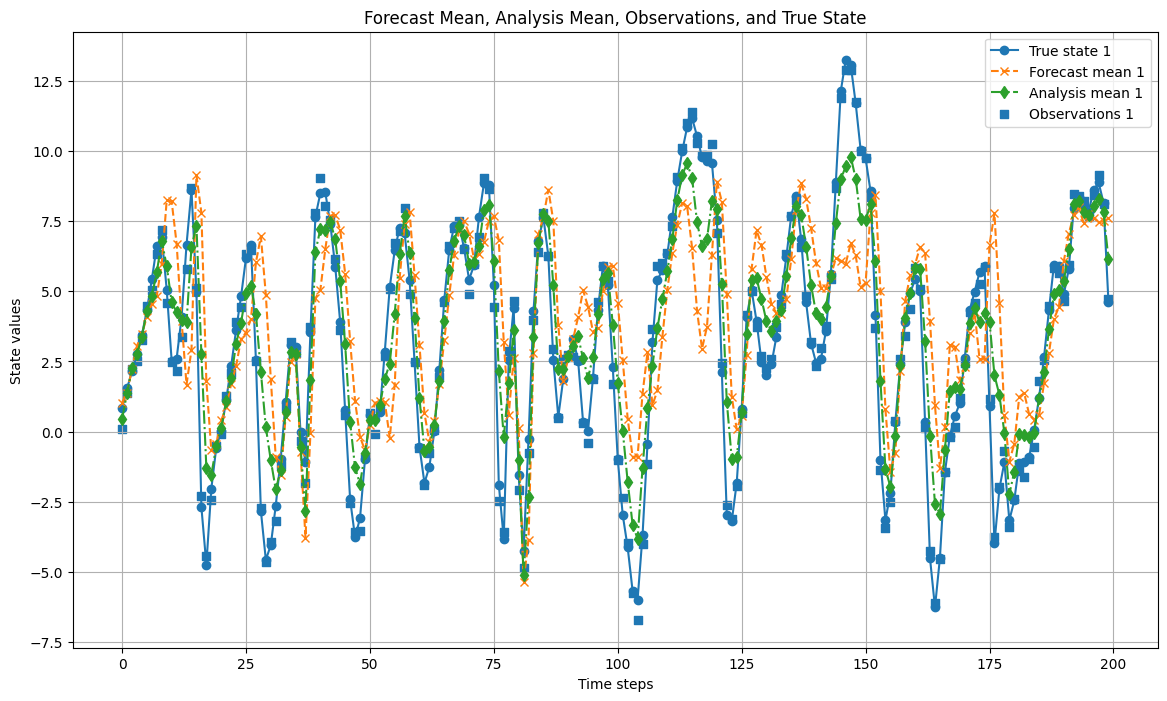

In [ ]:
time_steps = ensemble_forecast.shape[0]
time = jnp.arange(time_steps)

forecast_means = jnp.mean(ensemble_forecast, axis=2)
analysis_means = jnp.mean(ensemble_analysis, axis=2)

plt.figure(figsize=(14, 8))
i = 0
plt.plot(time, true_states[:, i], label=f'True state {i+1}', linestyle='-', marker='o')
plt.plot(time, forecast_means[:, i], label=f'Forecast mean {i+1}', linestyle='--', marker='x')
plt.plot(time, analysis_means[:, i], label=f'Analysis mean {i+1}', linestyle='-.', marker='d')
plt.scatter(time, observations[:, i], label=f'Observations {i+1}', marker='s')

plt.xlabel('Time steps')
plt.ylabel('State values')
plt.title('Forecast Mean, Analysis Mean, Observations, and True State')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast_means = jnp.mean(ensemble_forecast, axis=2)
analysis_means = jnp.mean(ensemble_analysis, axis=2)


In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

dt = 0.1  # time step
noise_const = 0.1
file = f"ACM270_Model_Error/testing_data_noise_{noise_const}_dt_{dt}.npz"
data = np.load(file)
forecast_state = data["forecast"]
analysis_state = data["analysis"]


class IncrementCorrectionModel(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(x.shape[-1])(x)  # Output layer should match input dimension
        return x

def create_model(key, input_shape, features):
    model = IncrementCorrectionModel(features)
    params = model.init(key, jnp.ones(input_shape))['params']
    return model, params

def loss_fn(params, apply_fn, x, y):
    predictions = apply_fn({'params': params}, x)
    loss = jnp.mean((predictions - y) ** 2)
    return loss

@jax.jit
def train_step(state, forecast_states, increments):
    def loss_fn_wrapper(params):
        return loss_fn(params, state.apply_fn, forecast_states, increments)

    grads = jax.grad(loss_fn_wrapper)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

def train_nn(state, forecast_states, analysis_states, num_epochs=10):
    increments = analysis_states - forecast_states

    for epoch in range(num_epochs):
        state = train_step(state, forecast_states, increments)
        current_loss = loss_fn(state.params, state.apply_fn, forecast_states, increments)
        print(f'Epoch {epoch+1}, Loss: {current_loss}')

    return state

key = jax.random.PRNGKey(0)
input_shape = (K,)
features = K
model, params = create_model(key, input_shape, features)

learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

num_epochs = 15
_,_,n = forecast_state.shape
for i in range(n):
  forecast_means = forecast_state[:,:,i]
  analysis_means = analysis_state[:,:,i]
  state = train_nn(state, forecast_means, analysis_means, num_epochs=num_epochs)


Epoch 1, Loss: 6.829021453857422
Epoch 2, Loss: 6.4329400062561035
Epoch 3, Loss: 6.096803188323975
Epoch 4, Loss: 5.812722206115723
Epoch 5, Loss: 5.571843147277832
Epoch 6, Loss: 5.367403984069824
Epoch 7, Loss: 5.1934685707092285
Epoch 8, Loss: 5.045270919799805
Epoch 9, Loss: 4.917848587036133
Epoch 10, Loss: 4.809329509735107
Epoch 11, Loss: 4.715566635131836
Epoch 12, Loss: 4.634082317352295
Epoch 13, Loss: 4.563183307647705
Epoch 14, Loss: 4.50112247467041
Epoch 15, Loss: 4.446829319000244
Epoch 1, Loss: 4.22346830368042
Epoch 2, Loss: 4.188257217407227
Epoch 3, Loss: 4.155224323272705
Epoch 4, Loss: 4.124021053314209
Epoch 5, Loss: 4.0943827629089355
Epoch 6, Loss: 4.066694259643555
Epoch 7, Loss: 4.040841579437256
Epoch 8, Loss: 4.016727924346924
Epoch 9, Loss: 3.9943323135375977
Epoch 10, Loss: 3.9735045433044434
Epoch 11, Loss: 3.9540634155273438
Epoch 12, Loss: 3.935537099838257
Epoch 13, Loss: 3.9178733825683594
Epoch 14, Loss: 3.9008681774139404
Epoch 15, Loss: 3.88445425

In [ ]:
#@partial(jax.jit, static_argnums=(3))
def ensrf_steps_nn(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, key, nn_params, model):
    def corrected_state_transition(v):
        transition = state_transition_function(v)
        correction = model.apply({'params': nn_params}, transition)
        return transition + correction

    model_vmap = jax.vmap(corrected_state_transition, in_axes=1, out_axes=1)
    key, *subkeys = jax.random.split(key, num=num_steps + 1)
    subkeys = jnp.array(subkeys)

    def inner(carry, t):
        ensemble, covar = carry
        ensemble_predicted = model_vmap(ensemble)
        _, C_forecast, ensemble_analysis, C_analysis = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, subkeys[t])
        return (ensemble_analysis, C_analysis), (ensemble_predicted, C_forecast, ensemble_analysis, C_analysis)

    n = len(Q[0])
    covariance_init = jnp.zeros((n, n))
    _, (ensemble_forecast, C_forecast, ensemble_analysis, C_analysis) = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    return ensemble_forecast, C_forecast, ensemble_analysis, C_analysis


In [ ]:
nn_params = state.params
ensemble_forecast_NN, C_forecast_NN, ensemble_analysis_NN, C_analysis_NN = ensrf_steps_nn(
    lorenz1,
    n_ensemble,
    ensemble_init,
    time_steps,
    observations,
    1,
    H,
    Q,
    R,
    key,
    nn_params,
    model
)

ensemble_forecast, C_forecast, ensemble_analysis, C_analysis = ensrf_steps(
    lorenz1,
    n_ensemble,
    ensemble_init,
    time_steps,
    observations,
    1,
    H,
    Q,
    R,
    key
)

time_steps = ensemble_forecast.shape[0]
time = jnp.arange(time_steps)

true_states = trajectory
forecast_means = jnp.mean(ensemble_forecast, axis=2)
analysis_means = jnp.mean(ensemble_analysis, axis=2)

forecast_means_NN = jnp.mean(ensemble_forecast_NN, axis=2)
analysis_means_NN = jnp.mean(ensemble_analysis_NN, axis=2)

plt.figure(figsize=(14, 8))

i = 0  # Index of the state variable to plot
plt.plot(time, true_states[:, i], label=f"True state {i+1}", linestyle="-", marker="o")
plt.plot(time, forecast_means[:, i], label=f"Forecast mean {i+1} (uncorrected)", linestyle="--", marker="x")
plt.plot(time, analysis_means[:, i], label=f"Analysis mean {i+1} (uncorrected)", linestyle="--", marker="x")
plt.plot(time, forecast_means_NN[:, i], label=f"Forecast mean {i+1} (corrected)", linestyle=":", marker="d")
plt.plot(time, analysis_means_NN[:, i], label=f"Analysis mean {i+1} (corrected)", linestyle=":", marker="d")
plt.scatter(time, observations[:, i], label=f"Observations {i+1}", marker="s")

plt.xlabel("Time steps")
plt.ylabel("State values")
plt.title("Comparison of Forecast and Analysis Means with True State and Observations")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'state' is not defined